In [7]:
import numpy as np
import random
import time
import pandas

from keras.callbacks import LambdaCallback

from keras import optimizers
from keras.layers import Activation, Input, LSTM, Dense, Dropout, BatchNormalization, GRU, Flatten, TimeDistributed
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import concatenate

from pandas import read_csv
from socketIO_client import SocketIO, LoggingNamespace
from Audio.Components.MidiPlayer import MidiPlayer

from sklearn.preprocessing import MinMaxScaler

from keras.utils.vis_utils import model_to_dot
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

In [8]:
# socket = SocketIO('localhost', 9876, LoggingNamespace)
# from MidiPlayer import MidiPlayer
player = MidiPlayer()

['IAC Driver Bus 1', 'IAC Driver LocalMidi']


In [9]:
dropout = 0.02
n_time_steps = 2
semi_redundancy_step = 3

In [10]:
corpus = read_csv('Audio/data/output.csv', header=1)
print(list(corpus))
print('corpus length:', len(corpus))

['0', ' 0.92', ' 18']
corpus length: 16


In [11]:
notes_index = corpus.values[:, 0]
length_index = corpus.values[:, 1]
print(note_index)
print(length_index)

NameError: name 'note_index' is not defined

In [12]:
lengths = []
first_field = np.arange(0.0, 1., 0.01)
for value in list(first_field):
    lengths.append(round(value, 2))
    
second_field = np.arange(1.0, 5.1, 0.1)
for value in list(second_field):
    lengths.append(round(value, 1))
    
print(lengths)

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0]


In [13]:
# notes = sorted(list(set(notes_index)))
# lengths = sorted(list(set(length_index)))
notes = []
for i in range(0, 128):
    notes.append(i)


    
print('num_events:', len(notes))
# print(notes)
note_index = dict((c, i) for i, c in enumerate(notes))
index_note = dict((i, c) for i, c in enumerate(notes))

lengths_index = dict((c, i) for i, c in enumerate(lengths))
index_lengths = dict((i, c) for i, c in enumerate(lengths))
print(lengths_index)
print(index_lengths)

num_events: 128
{0.0: 0, 0.01: 1, 0.02: 2, 0.03: 3, 0.04: 4, 0.05: 5, 0.06: 6, 0.07: 7, 0.08: 8, 0.09: 9, 0.1: 10, 0.11: 11, 0.12: 12, 0.13: 13, 0.14: 14, 0.15: 15, 0.16: 16, 0.17: 17, 0.18: 18, 0.19: 19, 0.2: 20, 0.21: 21, 0.22: 22, 0.23: 23, 0.24: 24, 0.25: 25, 0.26: 26, 0.27: 27, 0.28: 28, 0.29: 29, 0.3: 30, 0.31: 31, 0.32: 32, 0.33: 33, 0.34: 34, 0.35: 35, 0.36: 36, 0.37: 37, 0.38: 38, 0.39: 39, 0.4: 40, 0.41: 41, 0.42: 42, 0.43: 43, 0.44: 44, 0.45: 45, 0.46: 46, 0.47: 47, 0.48: 48, 0.49: 49, 0.5: 50, 0.51: 51, 0.52: 52, 0.53: 53, 0.54: 54, 0.55: 55, 0.56: 56, 0.57: 57, 0.58: 58, 0.59: 59, 0.6: 60, 0.61: 61, 0.62: 62, 0.63: 63, 0.64: 64, 0.65: 65, 0.66: 66, 0.67: 67, 0.68: 68, 0.69: 69, 0.7: 70, 0.71: 71, 0.72: 72, 0.73: 73, 0.74: 74, 0.75: 75, 0.76: 76, 0.77: 77, 0.78: 78, 0.79: 79, 0.8: 80, 0.81: 81, 0.82: 82, 0.83: 83, 0.84: 84, 0.85: 85, 0.86: 86, 0.87: 87, 0.88: 88, 0.89: 89, 0.9: 90, 0.91: 91, 0.92: 92, 0.93: 93, 0.94: 94, 0.95: 95, 0.96: 96, 0.97: 97, 0.98: 98, 0.99: 99, 1.0

In [14]:
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(length_index[:].reshape(-1,1))
# length_index = scaler.transform(length_index[:].reshape(-1,1))
# print(length_index[0:3])

In [15]:
length_phrases = []
next_length = []
note_phrases = []
next_note = []
for i in range(0, len(notes_index) - n_time_steps, semi_redundancy_step):
    note_phrases.append(notes_index[i: i + n_time_steps])
    length_phrases.append(length_index[i: i + n_time_steps])
    
    next_note.append(notes_index[i + n_time_steps])
    next_length.append(length_index[i + n_time_steps])
print('nb sequences:', len(note_phrases))
# for i in range(2):
#     print('______________')
#     print('note_x', note_phrases[i])
#     print('note_y', next_note[i])
#     print('length_x', length_phrases[i])
#     print('length_y', next_length[i])
print(length_phrases)
print(next_length)

nb sequences: 5
[array([0.65, 0.51]), array([1.4 , 0.05]), array([0.6 , 0.33]), array([0.09, 0.98]), array([1.3 , 0.51])]
[1.3, 0.93, 0.33, 1.3, 1.3]


In [16]:
print('Vectorization...')

note_x = np.zeros((len(note_phrases), n_time_steps, len(notes)), dtype=np.bool)
note_y = np.zeros((len(note_phrases), len(notes)), dtype=np.bool)

length_x = np.zeros((len(length_phrases), n_time_steps, len(lengths)), dtype=np.bool)
length_y = np.zeros((len(length_phrases), len(lengths)), dtype=np.bool)

for i, phrase in enumerate(note_phrases):
    for t, note in enumerate(phrase):
        print(i, t, note)
        note_x[i, t, note_index[note]] = 1
    note_y[i, note_index[next_note[i]]] = 1

for i, phrase in enumerate(length_phrases):
    for t, length in enumerate(phrase):
        print(i, t, length)
        length_x[i, t, lengths_index[length]] = 1
    length_y[i, lengths_index[next_length[i]]] = 1
    
# print('______________')
# print('length_x', length_x[0])
# print('length_y', length_y[0])
# print('note_x', note_x[0])
# print('note_y', note_y[0])

Vectorization...
0 0 58.0
0 1 57.0
1 0 52.0
1 1 61.0
2 0 0.0
2 1 50.0
3 0 53.0
3 1 52.0
4 0 55.0
4 1 52.0
0 0 0.65
0 1 0.51
1 0 1.4
1 1 0.05
2 0 0.6
2 1 0.33
3 0 0.09
3 1 0.98
4 0 1.3
4 1 0.51


In [17]:
print(note_x.shape)
print(length_x.shape)
print(note_y.shape)
print(length_y.shape)

(5, 2, 128)
(5, 2, 141)
(5, 128)
(5, 141)


In [18]:
lstm_size = 64

note_input = Input(name='note_input', shape=(n_time_steps, len(notes)))
length_input = Input(name='length_input', shape=(n_time_steps, len(lengths)))

# input_merge = concatenate([note_input, length_input])

# nn = LSTM(lstm_size, return_sequences=True)(input_merge)
# # nn = Dropout(dropout)(nn)
# nn = LSTM(lstm_size, return_sequences=True)(nn)

note_branch = LSTM(lstm_size, return_sequences=True)(note_input)
note_share = LSTM(int(lstm_size/4), return_sequences=True)(note_branch)

length_branch = LSTM(lstm_size, return_sequences=True)(length_input)
length_share = LSTM(int(lstm_size/4), return_sequences=True)(length_branch)

length_merge = concatenate([length_branch, note_share])
note_merge = concatenate([note_branch, length_share])

length_lstm = LSTM(lstm_size, return_sequences=False)(length_merge)
note_lstm = LSTM(lstm_size, return_sequences=False)(note_merge)
                    
output_notes = Dense(len(notes), activation='softmax', name='note_output')(note_lstm)
length_output = Dense(len(lengths), activation='softmax', name='length_output')(length_lstm)

optimizer = optimizers.RMSprop(lr=0.001)
model = Model(inputs=[note_input, length_input], outputs=[output_notes, length_output])
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=optimizer)

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 2, 128)       0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 2, 141)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 2, 64)        49408       note_input[0][0]                 
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 2, 64)        52736       length_input[0][0]               
__________________________________________________________________________________________________
lstm_4 (LS

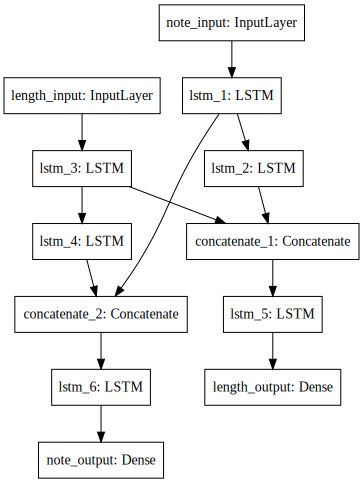

In [20]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [21]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [22]:
def midi_to_hertz(midi):
    if midi == 0:
        return 0
    g = 2**(1/12)
    return 440*g**(midi-69)

In [23]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    if epoch % 10 == 0 and epoch > 60:
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = 0
        for diversity in [1]:
            print('----- diversity:', diversity)

            generated_notes = []
            generated_length = []
            current_note_phrase = notes_index[start_index: start_index + n_time_steps]
            current_length_phrase = length_index[start_index: start_index + n_time_steps]
            generated_notes.extend(current_note_phrase)
            generated_length.extend(current_length_phrase)
    
            n_generated = 20
            start_time = time.time()
            for i in range(n_generated):
                x_pred = np.zeros((1, n_time_steps, len(notes)))
                length_x_pred = np.zeros((1, n_time_steps, len(lengths)))

                for t, event in enumerate(current_note_phrase):
                    x_pred[0, t, note_index[event]] = 1.

                for t, event in enumerate(current_length_phrase):
                    length_x_pred[0, t, lengths_index[event]] = 1

                pred = model.predict([x_pred, length_x_pred], verbose=0)
                note_pred = pred[0][0]
                length_pred = pred[1][0]
                
                note_index_from_sample = sample(note_pred, diversity)
                note_prediction = index_note[note_index_from_sample]
                
                length_index_from_sample = sample(length_pred, diversity)
                length_prediction = index_lengths[length_index_from_sample]
                
#                 print(note_prediction)
#                 print(length_prediction)
                
                generated_notes.append(note_prediction)
                generated_length.append(length_prediction)
                
                current_note_phrase = np.append(current_note_phrase[1:], note_prediction)
                current_length_phrase = np.append(current_length_phrase[1:], length_prediction)
                
                end_time = time.time()
            counter = 0
            for i in range(len(generated_notes)):
                note = generated_notes[i]
                length = generated_length[i]
#                 freq = midi_to_hertz(note)
                print(note, '|', length)
                player.play(note, length, 100)
#                     socket.emit('freq_change', {'freq': 4000, 'vol': 100})
                time.sleep(0.03)

                #socket.emit('freq_change', {'freq': freq, 'vol': 100})
                time.sleep(length * .5)


            #socket.emit('freq_change', {'freq': 0, 'vol': 100})

In [24]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit([note_x, length_x], [note_y, length_y],
          batch_size=256,
          epochs=50,
          callbacks=[print_callback]
        )

Epoch 1/50
5/5 [==============================] - 2s 380ms/step - loss: 9.8009 - note_output_loss: 4.8509 - length_output_loss: 4.9500
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 9.7635 - note_output_loss: 4.8330 - length_output_loss: 4.9305
Epoch 3/50
5/5 [==============================] - 0s 3ms/step - loss: 9.7332 - note_output_loss: 4.8187 - length_output_loss: 4.9145
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 9.7031 - note_output_loss: 4.8051 - length_output_loss: 4.8980
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 9.6713 - note_output_loss: 4.7907 - length_output_loss: 4.8806
Epoch 6/50
5/5 [==============================] - 0s 4ms/step - loss: 9.6371 - note_output_loss: 4.7757 - length_output_loss: 4.8614
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 9.5993 - note_output_loss: 4.7593 - length_output_loss: 4.8401
Epoch 8/50
5/5 [==============================] - 0s 4ms/step - los

In [26]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
